In [1]:
import pandas as pd
import string
import os
import itertools
import numpy as np
from sqlalchemy import create_engine, text

from utils import DbEngine, Queries
from etl import ETL
from encoder import Encoding

In [121]:
import numpy as np
import sys

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import calinski_harabasz_score, fowlkes_mallows_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn')

In [3]:
pd.set_option("display.max_columns", 100)

### Connect to DB

In [4]:
db_engine = DbEngine(user = 'team77', 
                     password = 'mintic2020.',
                     ip = '172.17.0.3', 
                     port = '5432', 
                     db = 'minjusticia')
engine = db_engine.connect()
queries = Queries(engine)

### Loading original data

In [5]:
data = pd.read_excel('../data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)

### Execute ETL

In [5]:
etl = ETL(queries)
etl.inmate_static_info(data)
etl.inmate_variable_info(data)

/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/etl.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['CONDIC_EXPECIONAL'] = data_reg['CONDIC_EXPECIONAL'].fillna('NINGUNO')
/home/jovyan/work/MinJusticia_team77_DS4A_Project/app/etl.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_reg['madre_gestante'] = 'NA'
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

### Functions

#### encodings

In [203]:
def encode_transform(data):
    encoders = []
    encoded_cols = []
    for i in range(data.values.shape[1]):
        le = LabelEncoder()
        le.fit(data.values[:,i])
        encoders.append(le)
        encoded_cols.append(le.transform(data.values[:,i]).reshape(-1,1))
    return np.concatenate(encoded_cols, axis = 1), encoders

#### metrics-results

In [205]:
def plot_confusion_matrix(labels, prediction, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.get_cmap('Blues')):
    """ Dibuja la matriz de confusion de los resultados de clasificacion de un modelo.
    Se puede aplicar normalizacion ajustando 'normalize=True'. """

    n = len(classes)
    if len(prediction.shape) != 1:
        matrix = multilabel_confusion_matrix(labels, prediction).reshape(n,4)
    else:
        matrix = confusion_matrix(labels, prediction)

    size = 1.4 * len(classes)
    plt.figure(figsize=(size, size))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))

    if len(prediction.shape) != 1:
        plt.xticks(tick_marks, ['True Negatives', 'False Negatives', 'False Positives', 'True Positives'], rotation=90)
    else:
        plt.xticks(tick_marks, classes, rotation=90)

    plt.yticks(tick_marks, classes)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment='center',
                 color='white' if matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [206]:
def classifier_results(prediction, labels, classes, show_plots):
    """ Muestra los resultados de accuracy, presenta los resultados de precision, recall y f1-score
    y genera la matriz de confusion para el conjunto de datos."""

    print('\nAccuracy:\n{0:.2f}'.format(accuracy_score(labels, prediction)))

    print(classification_report(labels, prediction, digits=2, target_names = classes))
    
    if show_plots:
        plot_confusion_matrix(labels, prediction, classes)

    return classification_report(labels, prediction, digits=2, output_dict=True)

In [207]:
def plot_roc(y_test, y_preds):
    """
    Helper function that plots the roc curve
    """
    plt.figure(figsize=(8,8))
    for label in np.unique(y_test):
        fpr, tpr, _ = roc_curve(y_test == label, y_preds == label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
        #plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic ROC')
    plt.legend(loc="lower right")
    plt.show()

In [216]:
def plot_precision_recall(y_test, y_preds):
    #plt.figure(figsize=(8,8))
    #for idx, label in enumerate(classes):
    #    roc_auc = auc(x[idx], y[idx])
    #    plt.plot(x[idx], y[idx], linewidth=2, label=str(label) + ': ' + 'AUC = ' + '{0:.2f}'.format(roc_auc) + ' - ' +
    #                                                               'AP = ' + '{0:.2f}'.format(ap[idx]) + ' - ' +
    #                                                               'F1 = ' + '{0:.2f}'.format(f1[idx]))
    #plt.xlim([0.0, 1.05])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('Recall')
    #plt.ylabel('Precision')
    #plt.title('Precision Recall Curve')
    #plt.legend(loc="lower right")
    #plt.grid()
    #plt.show()
    """
    Helper function that plots the roc precision recall Curve
    """
    plt.figure(figsize=(8,8))
    for label in np.unique(y_test):
        fpr, tpr, _ = precision_recall_curve(y_test == label, y_preds == label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
        #plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

#### algorithms

In [210]:
##### Get closest centroid unoptimized (Prediction Strength)
def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

In [211]:
##### Get closest centroid optimized v1 (Prediction Strength)
def get_closest_centroid_optim(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance)
    
    return centroids[idx_min_distance]

In [212]:
##### Get closest centroid optimized v2 (Prediction Strength)
def get_closest_centroid_optim_vectorized(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance, axis = 0)
    
    return centroids[idx_min_distance]

In [213]:
##### Get prediction strength unoptimized (Prediction Strength)
def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

In [214]:
##### Get prediction strength optimized (Prediction Strength)
def get_prediction_strength_optim(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    closest_cent = get_closest_centroid_optim_vectorized(x_test, train_centroids)
    
    co_membership = np.zeros((len(closest_cent), len(closest_cent)))
    for i in range(1, len(closest_cent)):
        diag = (closest_cent == np.roll(closest_cent, shift = i, axis = 0)).all(1)[i:]
        co_membership[range(i,len(closest_cent)),range(len(diag))] = diag
    co_membership = co_membership + co_membership.T - np.diag(np.diag(co_membership))
    
    # calculate the prediction strengths for each cluster
    n_test = len(x_test)
    ss = []
    for j in range(k):
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        test_labels_co_mem = np.zeros((len(test_labels), len(test_labels)))
        for i in range(len(test_labels)):
            diag = (test_labels == np.roll(test_labels, shift = i)) & (test_labels == j)
            diag = diag[i:]
            test_labels_co_mem[range(i,len(test_labels)),range(len(diag))] = diag
        test_labels_co_mem = test_labels_co_mem + test_labels_co_mem.T - np.diag(np.diag(test_labels_co_mem))
        s = (co_membership * test_labels_co_mem).sum()
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

### Encode

In [6]:
encoding = Encoding(queries)
data_2_encode = encoding.get_data()
data_encoded = encoding.one_hot(data_2_encode)

In [41]:
data_encoded

,internoen,genero,nacionalidad,estado_civil,nivel_educativo,reconocimiento_etnico,diversidad_sexual,extranjero,estado_ingreso,fecha_ingreso,establecimiento,fecha_salida,edad,actividades_estudio,actividades_trabajo,actividades_enseñanza,hijos_menores,condicion_excepcional,estado_id_estado,madre_gestante,madre_lactante,discapacidad,adulto_mayor,delito_CONCIERTO PARA DELINQUIR,delito_EXTORSION,delito_FABRICACION TRAFICO Y PORTE DE ARMAS Y MUNICIONES DE USO PRIVATIVO DE LAS FUERZAS ARMADAS,delito_FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO O MUNICIONES,"delito_FABRICACIÓN, TRÁFICO, PORTE O TENENCIA DE ARMAS DE FUEGO, ACCESORIOS, PARTES O MUNICIONES",delito_HOMICIDIO,delito_HURTO,delito_LESIONES PERSONALES,delito_OTRO,delito_TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES,delito_VIOLENCIA INTRAFAMILIAR,tentativa_1,tentativa_2,agravado_1,agravado_2,calificado_1,calificado_2
0,FD8EB8482F09C3F5FD085E4CAD29122368A5937B,2,22,3,2,5,1,1,4,2010-01-02,46,2011-07-01,35,2,1,1,2,NINGUNO,2,3,3,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1
1,7624E0648E28D778D1EE4581998B00C3ABC061DA,2,22,3,4,1,1,1,4,2010-01-02,113,2012-03-13,32,2,2,1,1,AFRO COLOMBIANO,2,3,3,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
2,2660D0E0F43523200EF105604266F18D6CA396E5,2,22,3,3,5,1,1,4,2010-01-03,98,2013-04-01,46,2,2,1,2,NINGUNO,2,3,3,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
3,00CD632E133B134F4CD3659080F8E5E7C1C7330A,2,22,3,3,5,1,1,4,2010-01-04,80,2010-01-29,50,1,1,1,2,NINGUNO,2,3,3,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0
4,7790E7531D616FDA7825C9CBB5502DD82DF35EB5,2,22,1,5,5,1,1,2,2010-01-05,146,2013-10-04,31,2,2,1,2,NINGUNO,2,3,3,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103285,C476DC9C78CBC61BC5A3D27699595E916D90E3E2,2,22,6,2,5,1,1,5,2020-06-05,123,None,35,1,1,1,2,NINGUNO,1,3,3,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
103286,AEB9E4C6773CBBE7C8424A52AB686E9F14101E73,2,22,7,10,5,1,1,4,2020-06-07,14,None,35,1,1,1,2,NINGUNO,1,3,3,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0
103287,92FBC965E9DE8CE7CD6AF95F4C460AF9A788CF59,2,22,6,4,5,1,1,4,2020-06-07,14,None,21,1,1,1,2,NINGUNO,1,3,3,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1
103288,BE6DD3C2939188AAFE3CD16E971D7F6C2BCEBC73,2,22,7,2,5,1,1,5,2020-06-08,46,None,42,1,1,1,2,NINGUNO,1,3,3,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,1


#### Fixing dataset lasts issues

Evaluando cantidad de columnas vacias aún

In [200]:
data_encoded.isnull().sum().to_frame().rename(columns={0:'counts'}).sort_values(by='counts', ascending = False)

,counts
fecha_salida,30304
internoen,0
discapacidad,0
delito_CONCIERTO PARA DELINQUIR,0
delito_EXTORSION,0
delito_FABRICACION TRAFICO Y PORTE DE ARMAS Y MUNICIONES DE USO PRIVATIVO DE LAS FUERZAS ARMADAS,0
delito_FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO O MUNICIONES,0
"delito_FABRICACIÓN, TRÁFICO, PORTE O TENENCIA DE ARMAS DE FUEGO, ACCESORIOS, PARTES O MUNICIONES",0
delito_HOMICIDIO,0
delito_HURTO,0


Evaluando qué columnas colo tienen un valor, pues de deben eliminar para el modelin

In [201]:
data_encoded.nunique().sort_values()

calificado_2                                                                                             2
delito_EXTORSION                                                                                         2
delito_CONCIERTO PARA DELINQUIR                                                                          2
adulto_mayor                                                                                             2
discapacidad                                                                                             2
delito_FABRICACIÓN, TRÁFICO, PORTE O TENENCIA DE ARMAS DE FUEGO, ACCESORIOS, PARTES O MUNICIONES         2
calificado_1                                                                                             2
estado_id_estado                                                                                         2
delito_HOMICIDIO                                                                                         2
hijos_menores                        

Eliminando columnas de fechas por ahora, id de inmate y columnas con menos de 2 variables únicas

In [202]:
data = data_encoded.drop(columns = ['internoen',
                                    'fecha_ingreso',
                                    'fecha_salida'])

Creando función para llevar a cabo un encoding nuevo, dado que aún hay variables no numéricas en los datos

In [204]:
data_enc, encoders = encode_transform(data)
data_enc

array([[ 1, 21,  2, ...,  1,  0,  1],
       [ 1, 21,  2, ...,  0,  1,  0],
       [ 1, 21,  2, ...,  0,  1,  0],
       ...,
       [ 1, 21,  5, ...,  1,  0,  1],
       [ 1, 21,  6, ...,  1,  1,  1],
       [ 1, 21,  5, ...,  0,  1,  0]])

### Unsupervised Learning with Kmeans

#### Elbow Plot (Within sum of squares distance)

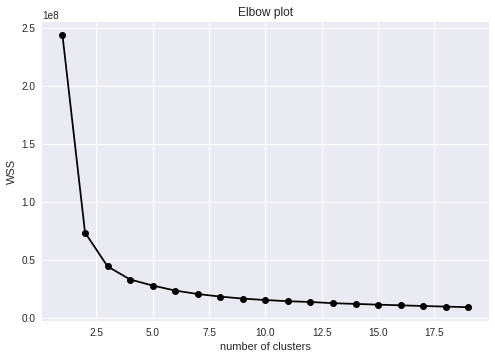

In [13]:
# setting the range of k
clusters = range(1, 20)

# running the clustering 
wss_list = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(data_enc)
    wss_list.append(model.inertia_)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

#### Prediction Strength

##### Data split

In [14]:
# train/test split
X_train, X_test = train_test_split(data_enc, 
                                   test_size=0.1, 
                                   shuffle=True, 
                                   random_state=42)

##### Running Optimized Implementation

In [20]:
# running the clustering 
strengths = []
clusters = range(2, 10)
for k in clusters:
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength_optim(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

In [ ]:
# plotting
### With 5% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

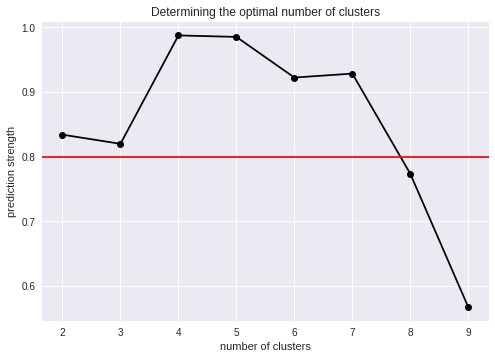

In [21]:
# plotting
### With 10% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

#### Fowlkes Mallows Score

In [ ]:
# setting the range of k
clusters = range(2, 20)
k_fowlkes_mallows = []
for k in clusters:
    model = KMeans(n_clusters = k, n_init = 100, random_state = 0)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = fowlkes_mallows_score(data_enc, cluster)
    
    k_fowlkes_mallows.append(round(score,2))

In [ ]:
# plotting
_, ax = plt.subplots()
ax.plot(clusters, k_fowlkes_mallows, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

#### Calinski Harabaz Score

In [22]:
# setting the range of k
clusters = range(2, 20)
k_calinski_harabasz = []
for k in clusters:
    model = KMeans(n_clusters = k, random_state=42)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = calinski_harabasz_score(data_enc, cluster)
    
    k_calinski_harabasz.append(round(score,2))

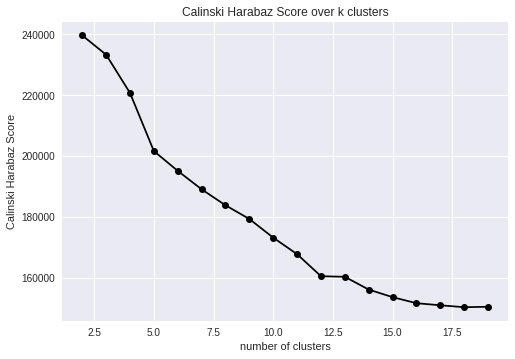

In [23]:
# plotting
_, ax = plt.subplots()
ax.plot(clusters, k_calinski_harabasz, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

#### Training Kmeans optimal Number of Clusters

In [224]:
final_kmeas = KMeans(n_clusters=4, random_state=42).fit(data_enc)
cluster_labels = final_kmeas.predict(data_enc)

#### Supervised Model to check feature importances

##### Data Spliting

In [225]:
# train/test split
X_train, X_test, Y_train, Y_test = train_test_split(data_enc, 
                                                    cluster_labels,
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=42)

In [226]:
data_enc.shape, cluster_labels.shape

((103290, 37), (103290,))

In [227]:
pd.DataFrame(cluster_labels, columns = ['Label'])['Label'].value_counts().to_frame()

,Label
0,33693
2,29677
3,23424
1,16496


##### Logistic Regression

In [228]:
clf_logistic = LogisticRegression(random_state=42,
                         max_iter = 100, 
                         solver = 'sag',
                         class_weight = 'balanced',
                         tol = 1e-3,
                         C = 0.01).fit(X_train, Y_train)

###### Evaluating training results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23538
           1       0.99      1.00      1.00     11613
           2       1.00      1.00      1.00     20713
           3       1.00      0.99      1.00     16439

    accuracy                           1.00     72303
   macro avg       1.00      1.00      1.00     72303
weighted avg       1.00      1.00      1.00     72303



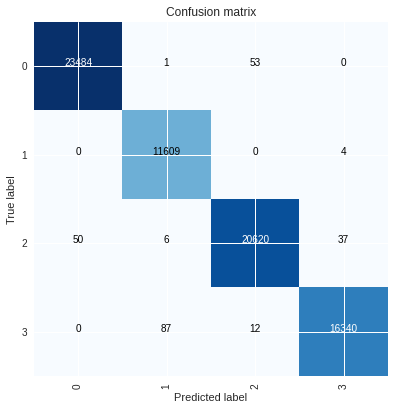

In [229]:
cr_train = classifier_results(prediction = pd.DataFrame(clf_logistic.predict(X_train))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in clf_logistic.classes_], 
                               show_plots = True)

###### Evaluating testing results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10155
           1       0.99      1.00      1.00      4883
           2       1.00      1.00      1.00      8964
           3       1.00      0.99      1.00      6985

    accuracy                           1.00     30987
   macro avg       1.00      1.00      1.00     30987
weighted avg       1.00      1.00      1.00     30987



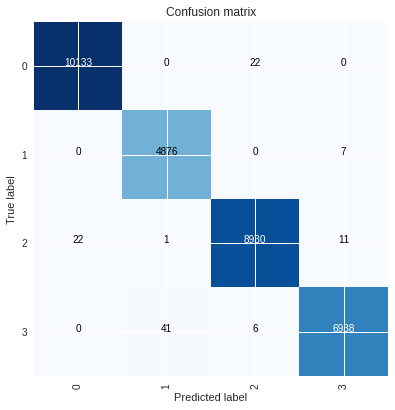

In [230]:
cr_test = classifier_results(prediction = pd.DataFrame(clf_logistic.predict(X_test))[0].astype(str).values, 
                           labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                           classes = [str(cl) for cl in clf_logistic.classes_], 
                           show_plots = True)

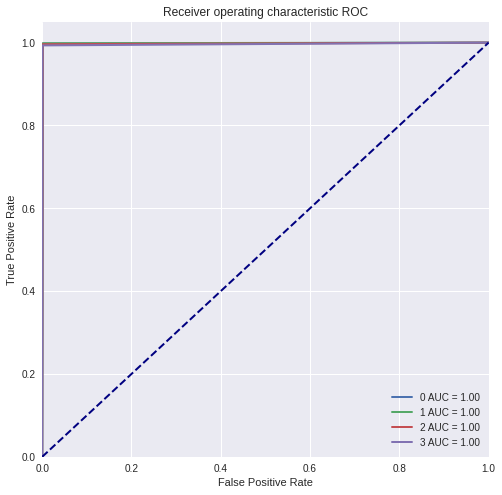

In [231]:
plot_roc(Y_test, clf_logistic.predict(X_test))

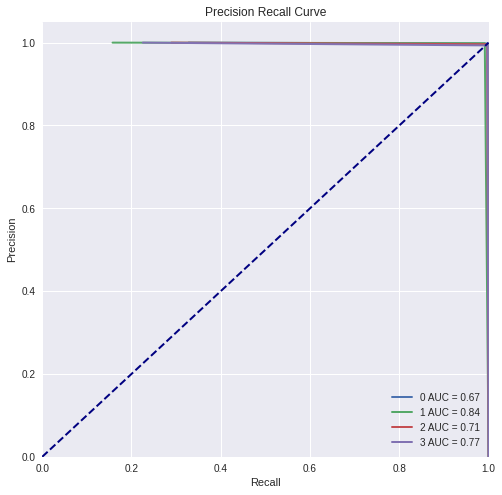

In [232]:
plot_precision_recall(Y_test, clf_logistic.predict(X_test))

###### Feature Importances

In [233]:
lg_coeffs = pd.DataFrame(clf_logistic.coef_, columns = data.columns) \
                        .T.reset_index().rename(columns = {'index':'feature'})
lg_coeffs

,feature,0,1,2,3
0,genero,0.102897,-0.121861,0.074360,-0.055396
1,nacionalidad,2.489234,-3.081846,1.190948,-0.598336
2,estado_civil,0.119735,-0.129572,0.050569,-0.040733
3,nivel_educativo,0.075550,-0.083122,0.037719,-0.030147
4,reconocimiento_etnico,0.151103,0.051227,-0.065298,-0.137031
5,diversidad_sexual,0.007991,-0.001849,-0.007755,0.001613
6,extranjero,0.006776,-0.055000,0.016932,0.031291
7,estado_ingreso,0.241487,-0.261183,0.078972,-0.059277
8,establecimiento,-1.094450,0.846167,-0.133636,0.381919
9,edad,0.023314,-0.014689,0.004731,-0.013355


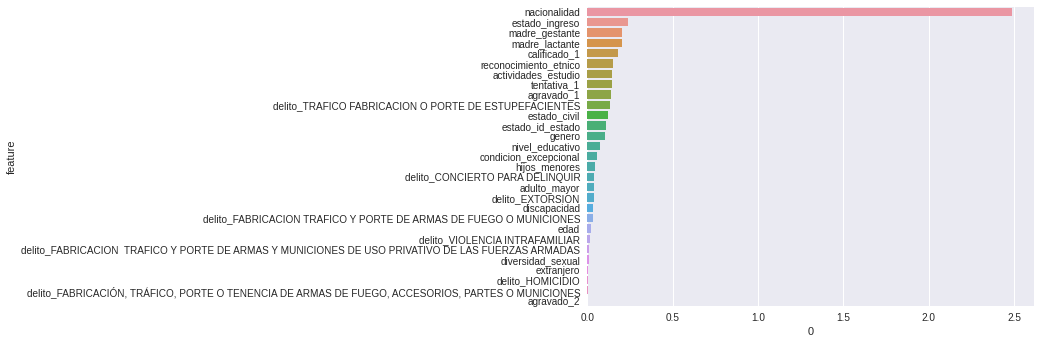

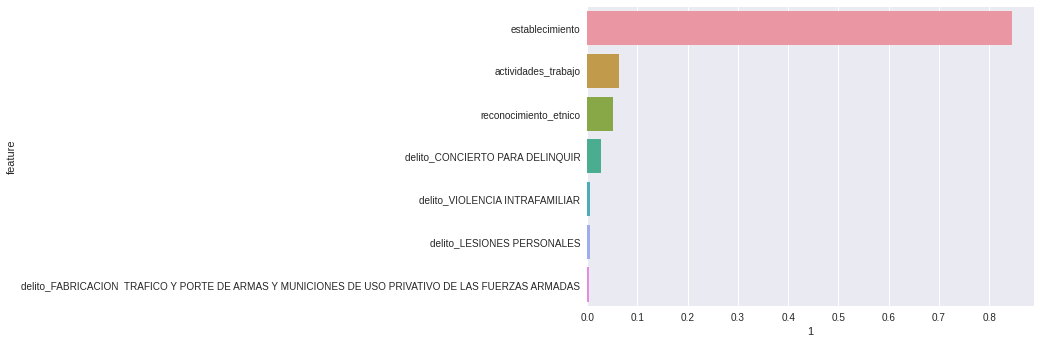

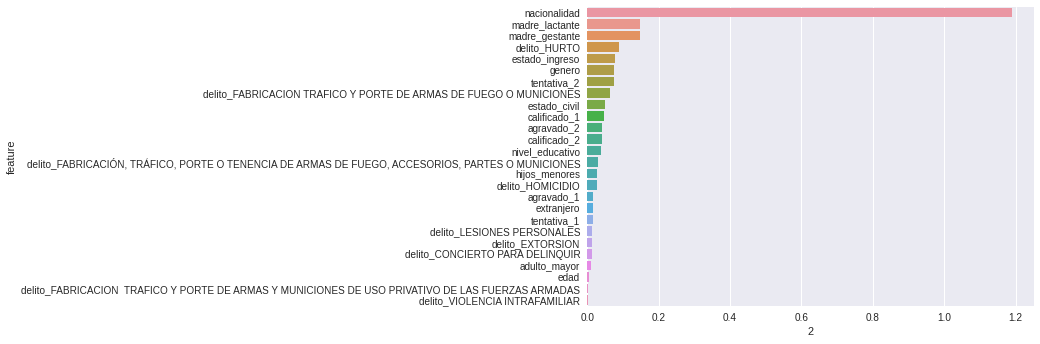

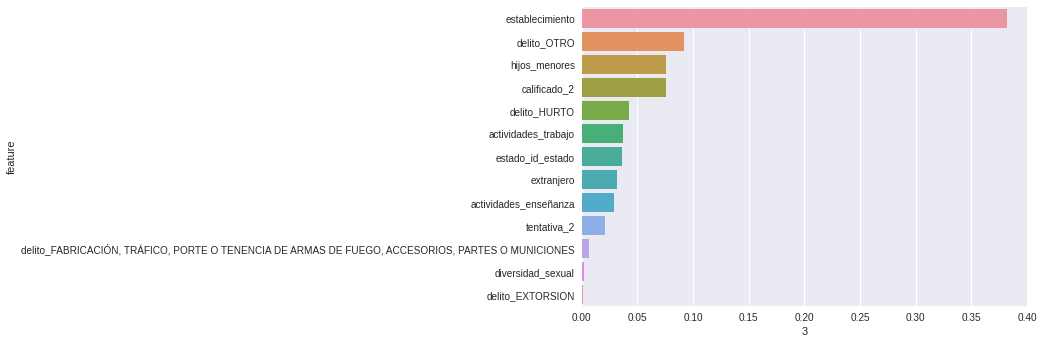

In [234]:
for i in range(4):
    d_cluster = lg_coeffs.sort_values(by=i, ascending = False)
    d_cluster = d_cluster[d_cluster[i] > 0]
    plt.figure(i)
    sns.barplot(x=i, y="feature" , data=d_cluster)

##### Random Forest Classifier

In [194]:
clf_randomf = RandomForestClassifier(random_state=42,
                                     class_weight = 'balanced',
                                     oob_score = True).fit(X_train, Y_train)

###### Evaluating training results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23538
           1       1.00      1.00      1.00     11613
           2       1.00      1.00      1.00     20713
           3       1.00      1.00      1.00     16439

    accuracy                           1.00     72303
   macro avg       1.00      1.00      1.00     72303
weighted avg       1.00      1.00      1.00     72303



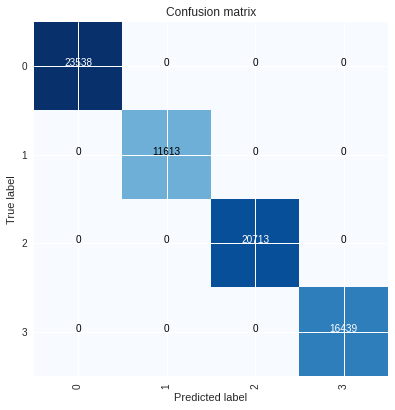

In [195]:
cr_train = classifier_results(prediction = pd.DataFrame(clf_randomf.predict(X_train))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in clf_randomf.classes_], 
                               show_plots = True)

###### Evaluating testing results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10155
           1       1.00      1.00      1.00      4883
           2       1.00      1.00      1.00      8964
           3       1.00      1.00      1.00      6985

    accuracy                           1.00     30987
   macro avg       1.00      1.00      1.00     30987
weighted avg       1.00      1.00      1.00     30987



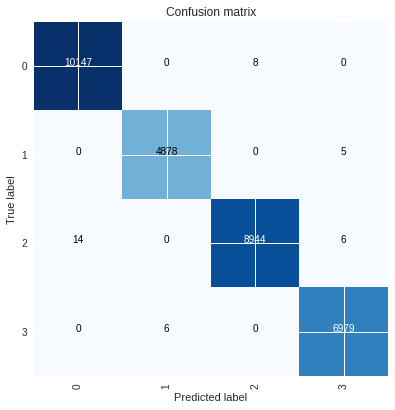

In [196]:
cr_test = classifier_results(prediction = pd.DataFrame(clf_randomf.predict(X_test))[0].astype(str).values, 
                           labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                           classes = [str(cl) for cl in clf_randomf.classes_], 
                           show_plots = True)

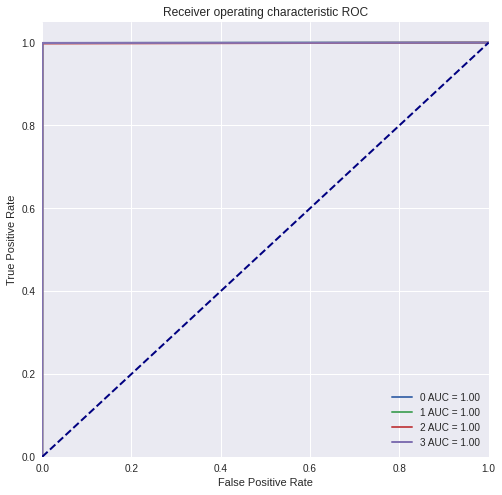

In [218]:
plot_roc(Y_test, clf_randomf.predict(X_test))

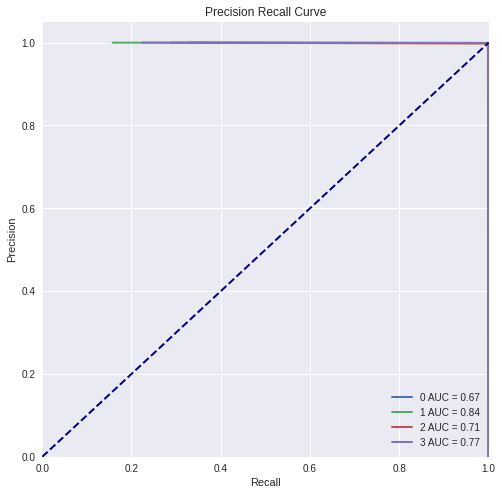

In [220]:
plot_precision_recall(Y_test, clf_randomf.predict(X_test))

###### Feature Importances

In [235]:
lg_coeffs = pd.DataFrame(clf.feature_importances_.reshape(1,-1), columns = data.columns) \
            .T.reset_index().rename(columns = {'index':'feature',
                                                0: 'feature_importance'}).sort_values(by=['feature_importance'], 
                                                                                      ascending = False)
lg_coeffs

,feature,feature_importance
8,establecimiento,0.863703
9,edad,0.026565
16,madre_gestante,0.012604
3,nivel_educativo,0.012488
0,genero,0.010739
7,estado_ingreso,0.009658
17,madre_lactante,0.007612
2,estado_civil,0.006272
10,actividades_estudio,0.003637
11,actividades_trabajo,0.003542


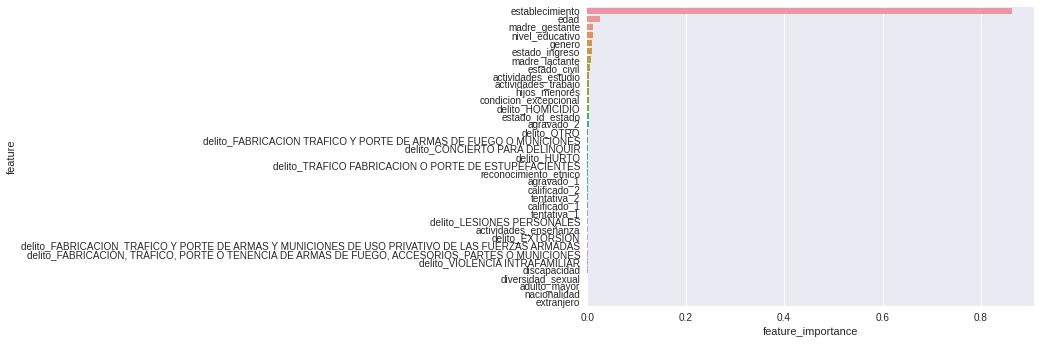

In [236]:
sns.barplot(x='feature_importance', y="feature", data=lg_coeffs)

### Unsupervised Learning with GMM

#### Elbow Plot (Within sum of squares distance)

In [128]:
gmm = GaussianMixture(n_components=5, covariance_type = 'diag', random_state=42)
gmm.fit(data_enc)
c_labels = gmm.predict(data_enc)

In [149]:
wss = 0
for k in np.unique(c_labels):
    c_idx = c_labels == k
    d_ck = data_enc[c_idx]
    center = gmm.means_[k]
    wss += ((d_ck - center) ** 2).sum()

In [ ]:
wss_list.append(model.means_.mean())

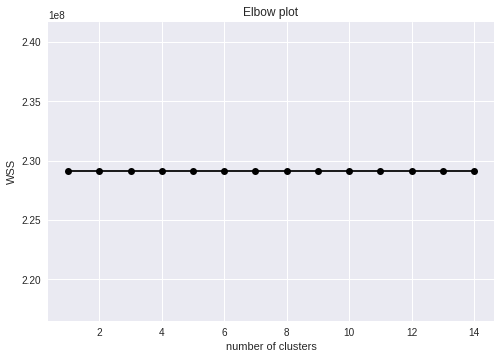

In [257]:
# setting the range of k
clusters = range(1, 15)

# running the clustering 
wss_list = []

for k in clusters:
    gmm = GaussianMixture(n_components=5, covariance_type = 'diag', random_state=42)
    gmm.fit(data_enc)
    c_labels = gmm.predict(data_enc)
    wss = 0
    for k in np.unique(c_labels):
        c_idx = c_labels == k
        d_ck = data_enc[c_idx]
        center = gmm.means_[k]
        wss += ((d_ck - center) ** 2).sum(1).sum()
    wss_list.append(wss)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

#### Prediction Strength

##### Data split

In [153]:
# train/test split
X_train, X_test = train_test_split(data_enc, 
                                   test_size=0.1, 
                                   shuffle=True, 
                                   random_state=42)

##### Running Optimized Implementation

In [154]:
# running the clustering 
strengths = []
clusters = range(2, 10)
for k in clusters:
    model_train = GaussianMixture(n_components=k, covariance_type = 'diag', random_state=42).fit(X_train)
    model_test = GaussianMixture(n_components=k, covariance_type = 'diag', random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength_optim(k, model_train.means_, X_test, model_test.predict(X_test))
    strengths.append(pred_str)

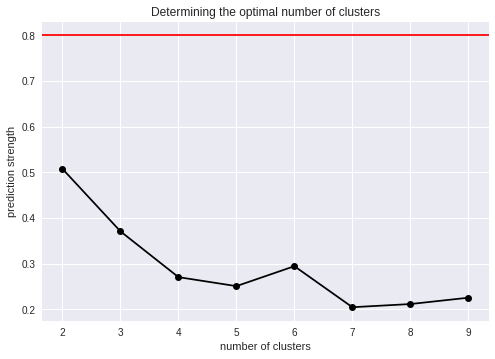

In [155]:
# plotting
### With 10% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

#### Calinski Harabaz Score

In [156]:
# setting the range of k
clusters = range(2, 20)
k_calinski_harabasz = []
for k in clusters:
    model = GaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = calinski_harabasz_score(data_enc, cluster)
    
    k_calinski_harabasz.append(round(score,2))

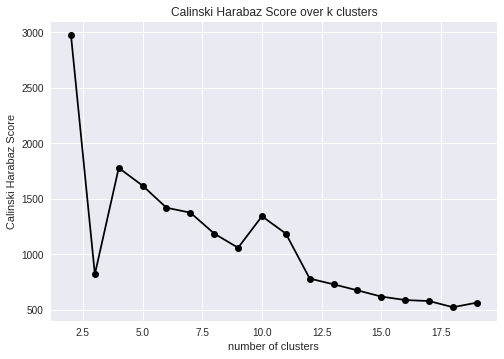

In [157]:
# plotting
_, ax = plt.subplots()
ax.plot(clusters, k_calinski_harabasz, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

#### Training GMM optimal Number of Clusters

In [237]:
final_gmm = GaussianMixture(n_components=4, covariance_type = 'diag', random_state=42).fit(data_enc)
cluster_labels = final_gmm.predict(data_enc)

#### Supervised Model to check feature importances

##### Data Spliting

In [238]:
# train/test split
X_train, X_test, Y_train, Y_test = train_test_split(data_enc, 
                                                    cluster_labels,
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=42)

In [239]:
data_enc.shape, cluster_labels.shape

((103290, 37), (103290,))

In [240]:
pd.DataFrame(cluster_labels, columns = ['Label'])['Label'].value_counts().to_frame()

,Label
2,80366
1,13381
0,7456
3,2087


##### Logistic Regression

In [241]:
clf_logistic = LogisticRegression(random_state=42,
                         max_iter = 100, 
                         solver = 'sag',
                         class_weight = 'balanced',
                         tol = 1e-3,
                         C = 0.01).fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


###### Evaluating training results


Accuracy:
0.72
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5218
           1       0.32      1.00      0.48      9325
           2       1.00      0.65      0.79     56262
           3       1.00      0.72      0.84      1498

    accuracy                           0.72     72303
   macro avg       0.81      0.83      0.76     72303
weighted avg       0.91      0.72      0.76     72303



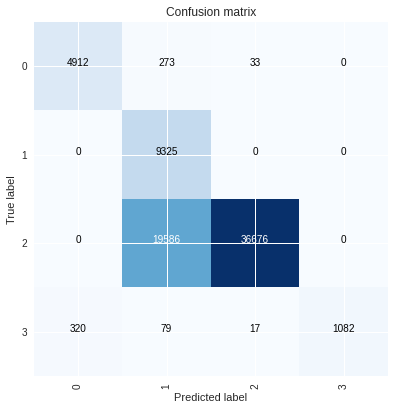

In [242]:
cr_train = classifier_results(prediction = pd.DataFrame(clf_logistic.predict(X_train))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in clf_logistic.classes_], 
                               show_plots = True)

###### Evaluating testing results


Accuracy:
0.72
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2238
           1       0.32      1.00      0.49      4056
           2       1.00      0.66      0.79     24104
           3       1.00      0.72      0.84       589

    accuracy                           0.72     30987
   macro avg       0.82      0.83      0.77     30987
weighted avg       0.91      0.72      0.76     30987



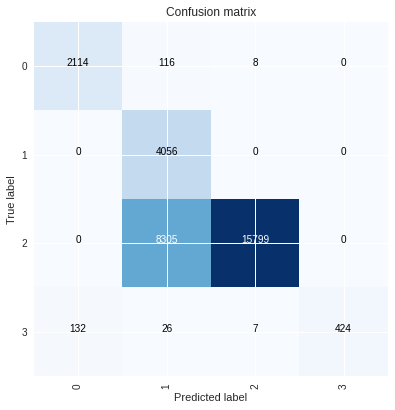

In [243]:
cr_test = classifier_results(prediction = pd.DataFrame(clf_logistic.predict(X_test))[0].astype(str).values, 
                           labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                           classes = [str(cl) for cl in clf_logistic.classes_], 
                           show_plots = True)

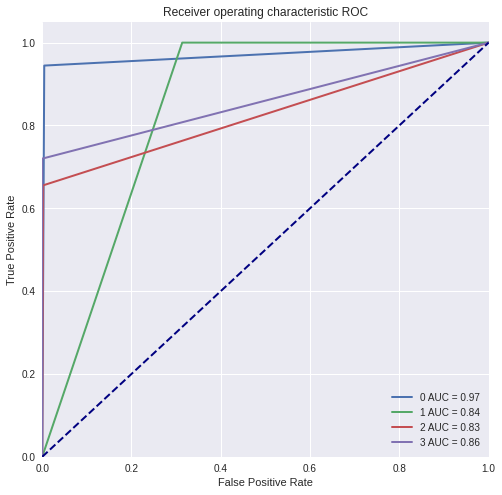

In [244]:
plot_roc(Y_test, clf_logistic.predict(X_test))

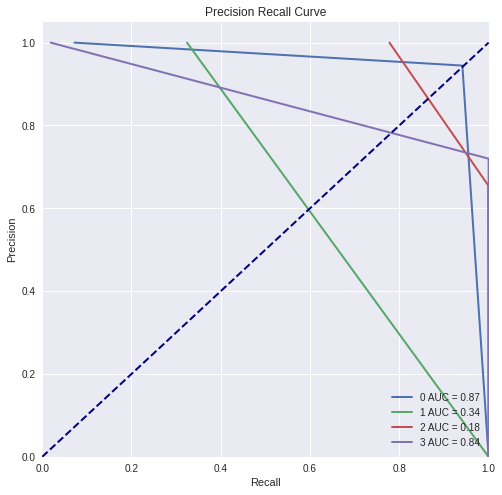

In [245]:
plot_precision_recall(Y_test, clf_logistic.predict(X_test))

###### Feature Importances

In [259]:
lg_coeffs = pd.DataFrame(clf_logistic.coef_, columns = data.columns) \
                        .T.reset_index().rename(columns = {'index':'feature'})
lg_coeffs

,feature,0,1,2,3
0,genero,-0.814205,-0.143099,0.873027,0.084277
1,nacionalidad,1.567185,-1.436749,-1.002696,0.872260
2,estado_civil,0.114621,-0.201403,-0.213339,0.300121
3,nivel_educativo,0.103517,-0.087157,-0.214043,0.197682
4,reconocimiento_etnico,-1.147348,0.261867,0.820858,0.064622
5,diversidad_sexual,3.935474,-2.409975,-1.802298,0.276799
6,extranjero,-1.518907,-0.671265,-1.268004,3.458176
7,estado_ingreso,0.165209,-0.260148,-0.362889,0.457828
8,establecimiento,0.028979,0.004696,-0.019963,-0.013711
9,edad,0.046621,0.005967,0.000216,-0.052804


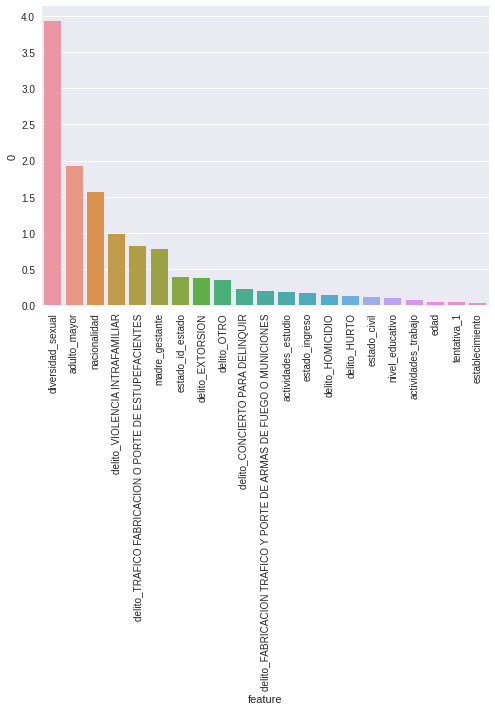

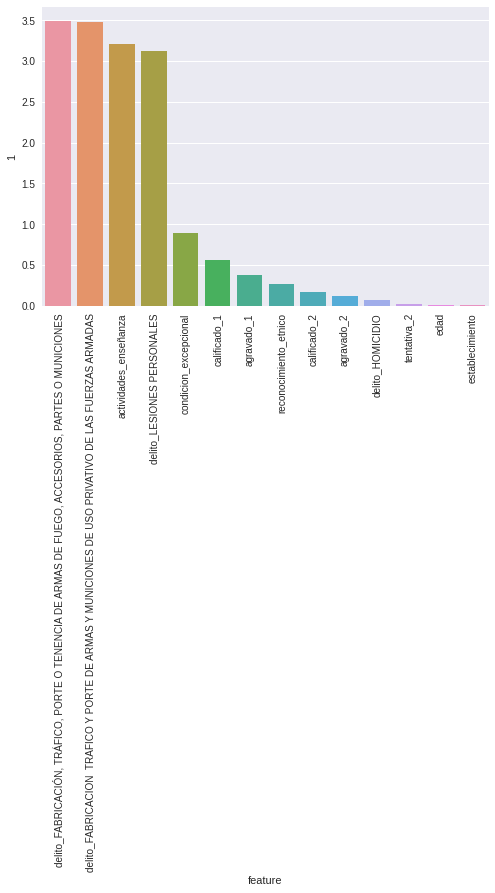

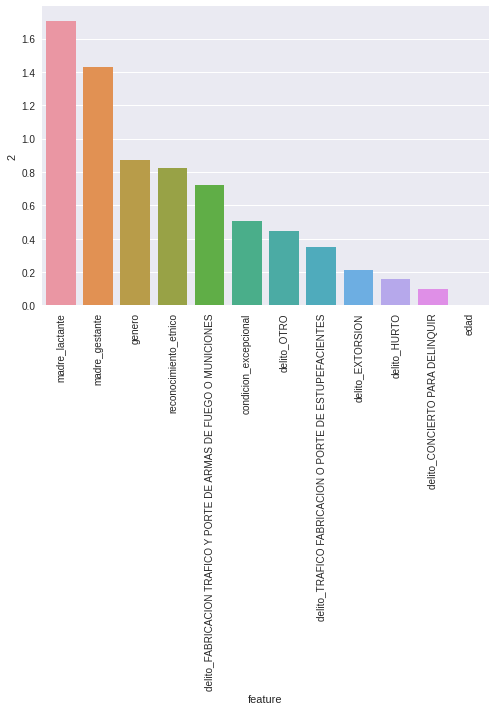

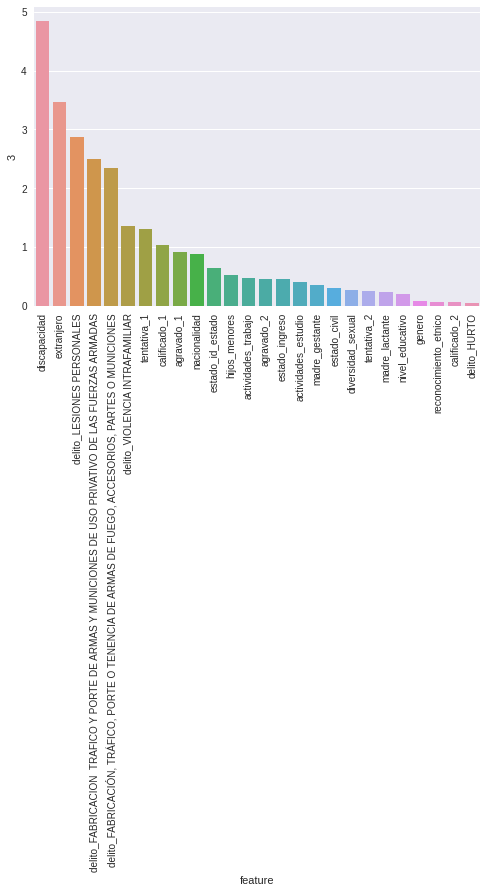

In [261]:
for i in range(4):
    d_cluster = lg_coeffs.sort_values(by=i, ascending = False)
    d_cluster = d_cluster[d_cluster[i] > 0]
    plt.figure(i)
    sns.barplot(x="feature", y=i , data=d_cluster)
    plt.xticks(rotation=90)

##### Random Forest Classifier

In [248]:
clf_randomf = RandomForestClassifier(random_state=42,
                                     class_weight = 'balanced',
                                     oob_score = True).fit(X_train, Y_train)

###### Evaluating training results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5218
           1       1.00      1.00      1.00      9325
           2       1.00      1.00      1.00     56262
           3       1.00      1.00      1.00      1498

    accuracy                           1.00     72303
   macro avg       1.00      1.00      1.00     72303
weighted avg       1.00      1.00      1.00     72303



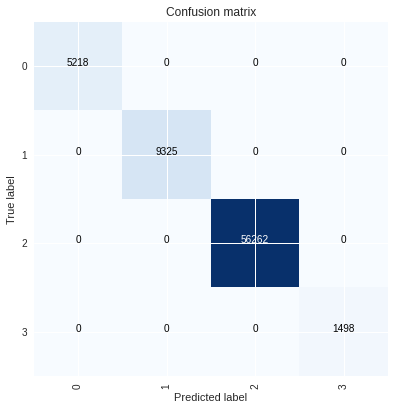

In [249]:
cr_train = classifier_results(prediction = pd.DataFrame(clf_randomf.predict(X_train))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in clf_randomf.classes_], 
                               show_plots = True)

###### Evaluating testing results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2238
           1       1.00      1.00      1.00      4056
           2       1.00      1.00      1.00     24104
           3       1.00      0.98      0.99       589

    accuracy                           1.00     30987
   macro avg       1.00      1.00      1.00     30987
weighted avg       1.00      1.00      1.00     30987



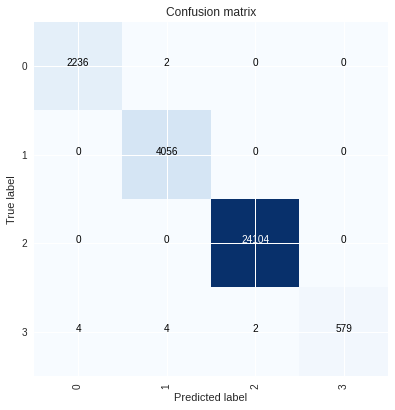

In [250]:
cr_test = classifier_results(prediction = pd.DataFrame(clf_randomf.predict(X_test))[0].astype(str).values, 
                           labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                           classes = [str(cl) for cl in clf_randomf.classes_], 
                           show_plots = True)

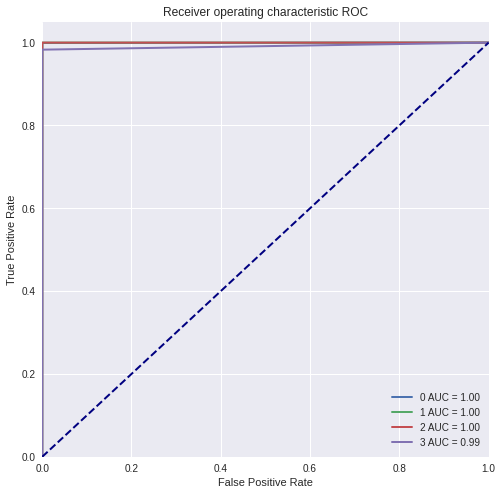

In [254]:
plot_roc(Y_test, clf_randomf.predict(X_test))

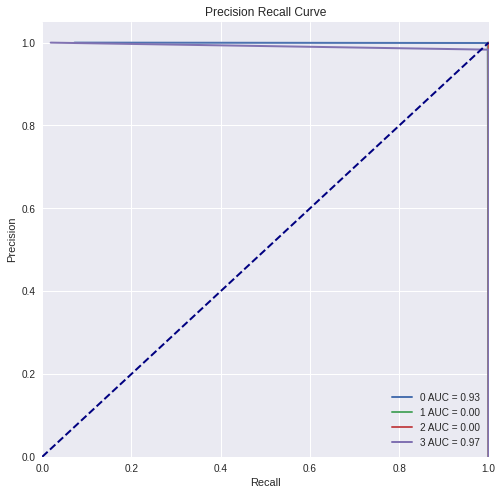

In [253]:
plot_precision_recall(Y_test, clf_randomf.predict(X_test))

###### Feature Importances

In [265]:
lg_coeffs = pd.DataFrame(clf_randomf.feature_importances_.reshape(1,-1), columns = data.columns) \
            .T.reset_index().rename(columns = {'index':'feature',
                                                0: 'feature_importance'}).sort_values(by=['feature_importance'], 
                                                                                      ascending = False)
lg_coeffs

,feature,feature_importance
14,condicion_excepcional,0.272309
18,discapacidad,0.140888
4,reconocimiento_etnico,0.089605
27,delito_LESIONES PERSONALES,0.067487
22,delito_FABRICACION TRAFICO Y PORTE DE ARMAS Y...,0.065272
24,"delito_FABRICACIÓN, TRÁFICO, PORTE O TENENCIA ...",0.063212
12,actividades_enseñanza,0.040182
16,madre_gestante,0.040021
17,madre_lactante,0.032053
0,genero,0.030959


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]),
 <a list of 37 Text major ticklabel objects>)

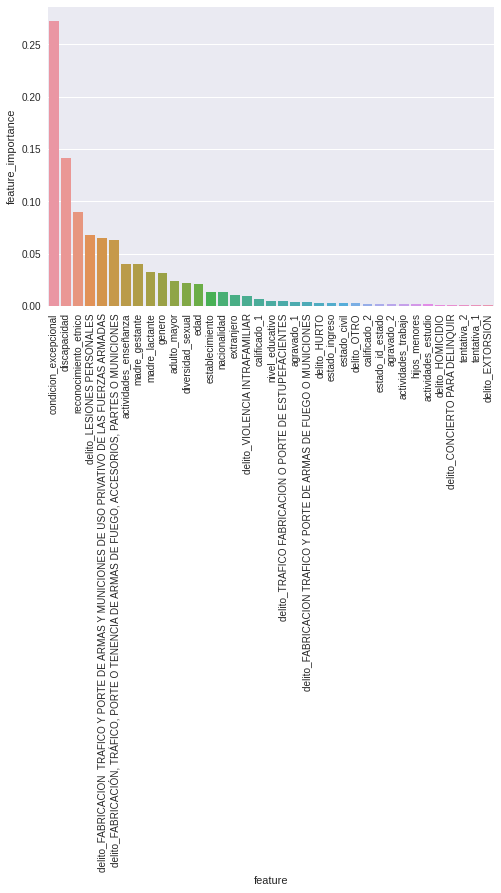

In [267]:
plt.figure()
sns.barplot(x='feature', y="feature_importance", data=lg_coeffs)
plt.xticks(rotation=90)